In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()

In [2]:
ilc = pd.read_csv(r'C:\Users\dvale\TFM\Data\ilc.csv', low_memory=False)

In [3]:
def unflag(column_series):
    unflaged_list = list(column_series)
    for c in column_series:
        if c[-6:] == '(flag)':
            unflaged_list.remove(c)
    return unflaged_list

unflaged_columns = unflag(ilc.columns)
ilc = ilc[unflaged_columns]

In [4]:
irrelevant_columns = ['Unnamed: 0', 
                      'Year of survey', 
                      'Country', 
                      'Personal ID', 
                      'Month of birth', 
                      'Father ID', 
                      'Mother ID', 
                      'Spouse/partner ID', 
                      'Month of the personal interview', 
                      'Year of the personal interview', 
                      'Minutes to complete the personal questionnaire', 
                      'Household ID', 
                      'Primary sampling units (PSU)', 
                      'Houshold cross-sectional weight', 
                      'Month of household interview', 
                      'Year of household interview', 
                      'Person responding the household questionnaire', 
                      'Person 1 responsible for the accommodation', 
                      'Person 2 responsible for the accommodation', 
                      'Number of minutes to complete the household questionnaire',
                      'Residential status']

ilc = ilc.drop(irrelevant_columns, axis=1)

In [5]:
for c in ilc.columns:
    print(c)

Personal cross-sectional weight
Year of birth
Sex
Basic activity status
Education at pre-school
Education at compulsory school
Childcare at centre-based services
Childcare at day-care centre
Childcare by a professional child-minder at child's home or at child-minder’s home
Childcare by grand-parents, other household members (outside parents), other relatives, friends or neighbours
Childrens’ cross-sectional weight for childcare
Living in household with low employement level
Living in household under risk of poverty
Marital status
Consensual Union
Country of birth
Citizenship
Current education activity
ISCED level currently attended
Year when highest level of education was attained
Highest ISCED level attained
Self-defined current economic status
Whether person has ever worked
Actively looking for a job
Available for work
Status in employment
Occupation
Number of hours usually worked per week in main job
Number of months spent at full-time work as employee
Number of months spent at part

In [6]:
sociodemo = pd.DataFrame()

In [7]:
sociodemo['weight'] = ilc['Personal cross-sectional weight']
sociodemo.head()

,weight
0,906.15830
1,906.15830
2,1227.68869
3,1227.68869
4,2559.35987


In [8]:
def weighted_freq(df, cat_column):
    dummy = pd.get_dummies(cat_column)
    for c in dummy.columns:
        dummy['weight_' + str(c)] = dummy[c] * df.weight
    freq_dict = {}
    for c in dummy.columns:
        if str(c)[0] == 'w':
            freq_dict[c[7:]] = dummy[c].sum() / df.weight.sum()
    return freq_dict

def weighted_cat(df, cat_column):
    dummy = pd.get_dummies(cat_column)
    for c in dummy.columns:
        dummy['weight_' + c] = dummy[c] * df.weight
    weighted_cat = []
    for i in range(len(df)):
        for c in dummy.columns:
            if c[0] == 'w':
                for x in range(int(round(dummy[c][i]/1000, 0))):
                       weighted_cat.append(c[7:])   
    return weighted_cat

def weighted_num(df, num_column):
    weighted_num = []
    for i in range(len(df)):
        for x in range(int(round(df.weight[i]/1000, 0))):
            weighted_num.append(num_column[i])  
    return weighted_num

In [9]:
sociodemo['sex'] = ilc['Sex']
sociodemo.head()

,weight,sex
0,906.15830,Male
1,906.15830,Female
2,1227.68869,Female
3,1227.68869,Male
4,2559.35987,Female


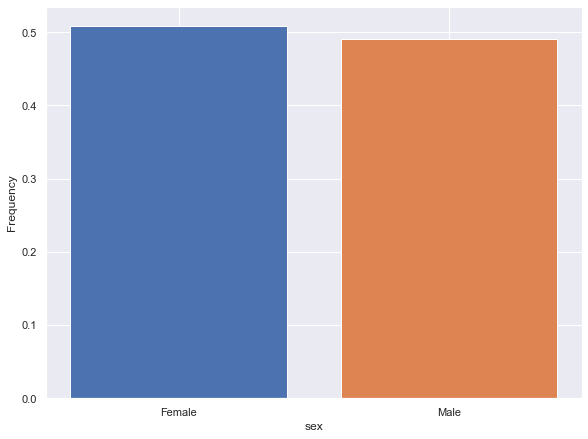

In [10]:
def barplot(x, data, legend=False):
    labels = sorted(data[x].unique())
    label_colors = ['C'+str(i) for i in range(len(labels))]
    x_ticks = range(len(labels))
    freq = weighted_freq(data, data[x])
    plt.figure(figsize=(6.4*1.5, 4.8*1.5))
    ax = plt.subplot()
    ax.bar(x_ticks, [freq[label] for label in labels], color=label_colors)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(labels)
    plt.xlabel(x)
    plt.ylabel('Frequency')
    if legend==False:
        ax.set_xticklabels(labels)
    else:
        ax.set_xticklabels(['' for label in labels])
        for i in range(len(labels)):
            ax.bar([0], [0], label=labels[i], color=label_colors[i])
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

barplot(x='sex', data=sociodemo);

In [11]:
sociodemo['age'] = ilc['Year of birth'].apply(lambda x: 2019-x)
sociodemo.head()

,weight,sex,age
0,906.15830,Male,70
1,906.15830,Female,68
2,1227.68869,Female,72
3,1227.68869,Male,60
4,2559.35987,Female,54


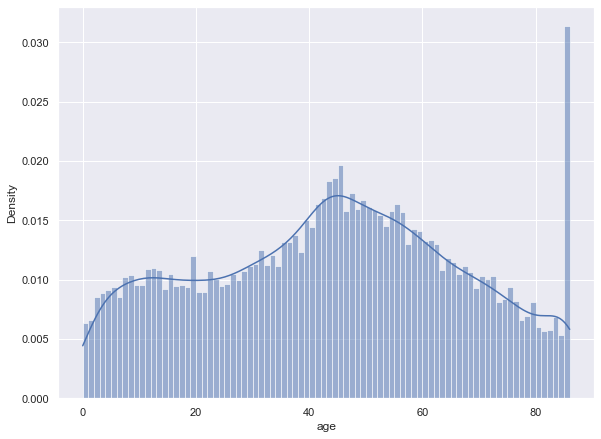

In [12]:
plt.figure(figsize=(6.4*1.5, 4.8*1.5))
sns.histplot(x='age', data=sociodemo, weights='weight', bins=86, stat='density', kde=True);

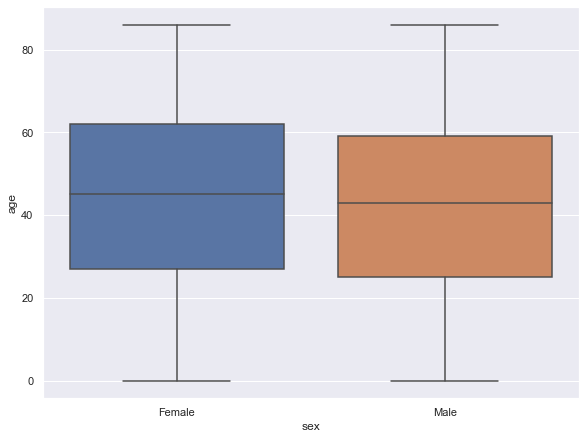

In [13]:
def boxplot(x, y, data):
    weighted = pd.DataFrame({x: weighted_cat(data, data[x]), y: weighted_num(data, data[y])})
    plt.figure(figsize=(6.4*1.5, 4.8*1.5))
    sns.boxplot(x=x, y=y, data=weighted, order=sorted(data[x].unique()))
    
boxplot(x='sex', y='age', data=sociodemo)

In [14]:
ilc['Basic activity status'].unique()

array(['In retirement or early retirement or has given up business',
       'Other inactive person', 'Unemployed', 'At work', nan],
      dtype=object)

In [15]:
sociodemo['economic_status'] = ilc['Basic activity status']

mapped_economic_status = {'At work': 'Employed',
                          'Unemployed': 'Unemployed',
                          'In retirement or early retirement or has given up business': 'Retired',
                          'Other inactive person': 'Other'}

sociodemo.economic_status = sociodemo.economic_status.map(mapped_economic_status).fillna('Other')

sociodemo.head()

,weight,sex,age,economic_status
0,906.15830,Male,70,Retired
1,906.15830,Female,68,Other
2,1227.68869,Female,72,Other
3,1227.68869,Male,60,Retired
4,2559.35987,Female,54,Other


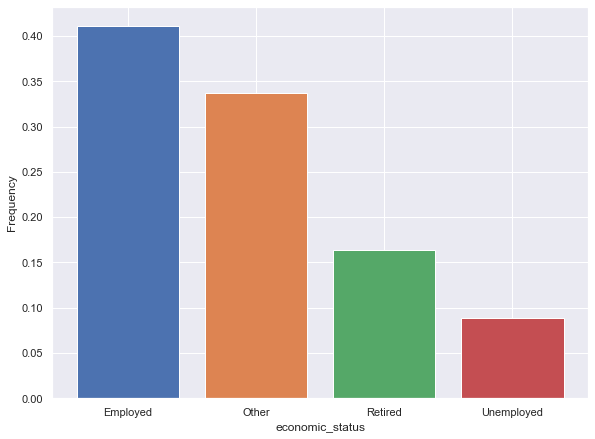

In [16]:
barplot(x='economic_status', data=sociodemo);

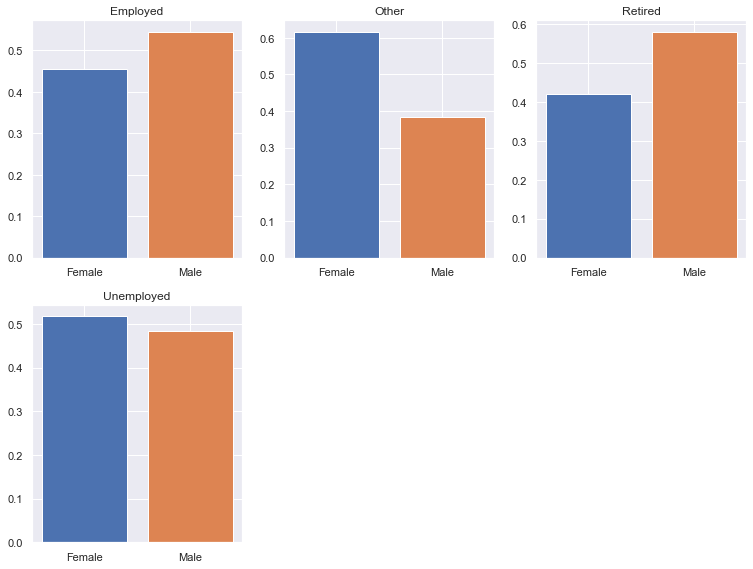

In [17]:
def length_calculator(labels):
    a = 4
    multiplier = 1
    rows = 2
    for i in range(labels):
        if i+1 > a + 3:
            a += 3
            multiplier += 0.5
            rows += 1
    return multiplier, rows

def bardiagram(x, hue, data, legend=False):
    titles = sorted(data[x].unique())
    labels = sorted(data[hue].unique())
    label_colors = ['C'+str(i) for i in range(len(labels))]
    x_ticks = range(len(labels))
    length_multiplier, subplot_rows = length_calculator(len(titles))
    plt.figure(figsize=(6.4*2, 4.8*2*length_multiplier))
    subplot = 1
    for title in titles:
        subplot_data = data[data[x] == title]
        freq = weighted_freq(subplot_data, subplot_data[hue])
        ax = plt.subplot(subplot_rows, 3, subplot)
        ax.title.set_text(title)
        ax.bar(x_ticks, [freq[label] if label in freq.keys() else 0 for label in labels], color=label_colors)
        ax.set_xticks(x_ticks)
        if legend==False:
            ax.set_xticklabels(labels)
        else:
            ax.set_xticklabels(['' for label in labels])
        subplot += 1
    if legend==True:
        for i in range(len(labels)):
            ax.bar([0], [0], label=labels[i], color=label_colors[i])
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
bardiagram(x='economic_status', hue='sex', data=sociodemo)

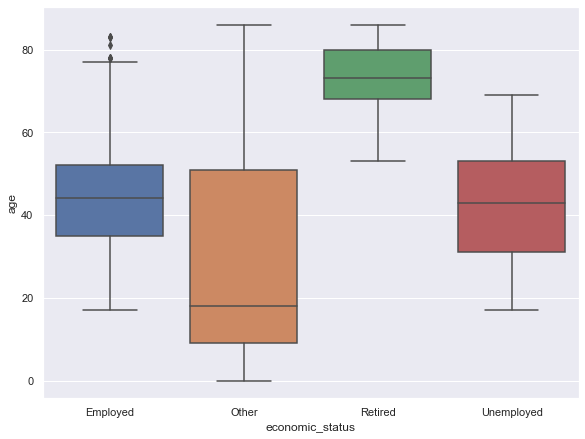

In [18]:
boxplot(x='economic_status', y='age', data=sociodemo)

In [19]:
ilc['Marital status'].unique()

array(['Married', 'Divorced', 'Never married', 'Widowed', nan,
       'Separated'], dtype=object)

In [20]:
civil_status = pd.DataFrame({'weight': ilc['Personal cross-sectional weight']})
civil_status['legal_status'] = ilc['Marital status']
civil_status.legal_status = civil_status.legal_status.fillna('Never married')
civil_status.head()

,weight,legal_status
0,906.15830,Married
1,906.15830,Married
2,1227.68869,Married
3,1227.68869,Married
4,2559.35987,Divorced


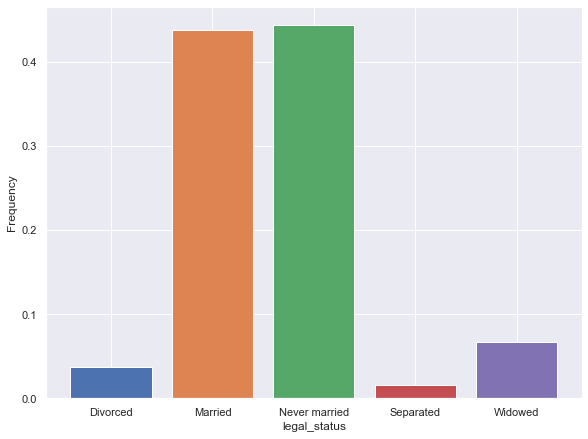

In [21]:
barplot(x='legal_status', data=civil_status)

In [22]:
ilc['Consensual Union'].unique()

array(['Yes, with legal basis', 'No', nan, 'Yes, without legal basis'],
      dtype=object)

In [23]:
civil_status['consensual_union'] = ilc['Consensual Union']
civil_status.consensual_union = civil_status.consensual_union.fillna('Missing')
civil_status.head()

,weight,legal_status,consensual_union
0,906.15830,Married,"Yes, with legal basis"
1,906.15830,Married,"Yes, with legal basis"
2,1227.68869,Married,"Yes, with legal basis"
3,1227.68869,Married,"Yes, with legal basis"
4,2559.35987,Divorced,No


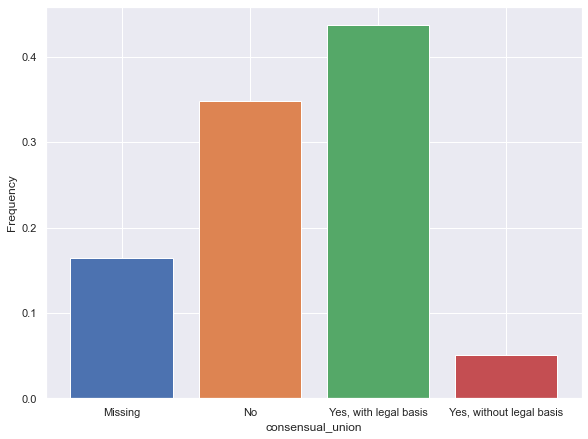

In [24]:
barplot(x='consensual_union', data=civil_status)

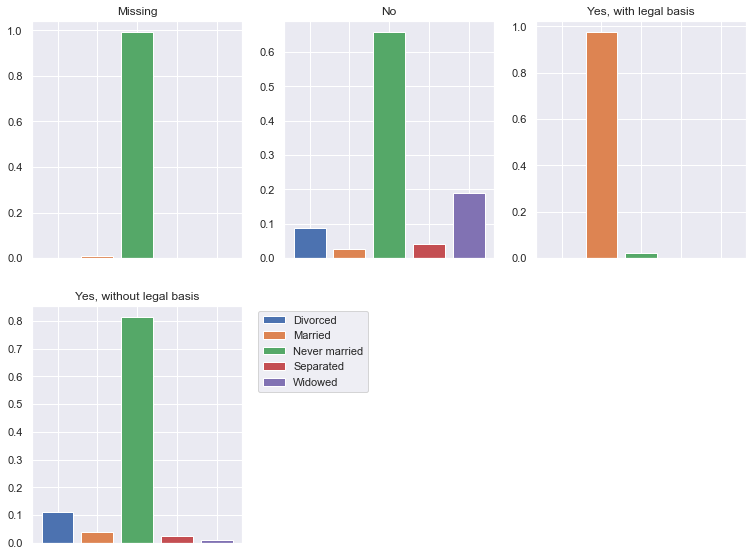

In [25]:
bardiagram(x='consensual_union', hue='legal_status', data=civil_status, legend=True)

In [26]:
civil_status['civil_status+'] = civil_status.apply(lambda row: "Married 'de facto'" 
                                                    if row['consensual_union'] == 'Yes, without legal basis' 
                                                    and row['legal_status'] == 'Never married'
                                                    else row['legal_status'],
                                                    axis=1)
civil_status.head()

,weight,legal_status,consensual_union,civil_status+
0,906.15830,Married,"Yes, with legal basis",Married
1,906.15830,Married,"Yes, with legal basis",Married
2,1227.68869,Married,"Yes, with legal basis",Married
3,1227.68869,Married,"Yes, with legal basis",Married
4,2559.35987,Divorced,No,Divorced


In [27]:
sociodemo['civil_status'] = civil_status['civil_status+']
sociodemo.head()

,weight,sex,age,economic_status,civil_status
0,906.15830,Male,70,Retired,Married
1,906.15830,Female,68,Other,Married
2,1227.68869,Female,72,Other,Married
3,1227.68869,Male,60,Retired,Married
4,2559.35987,Female,54,Other,Divorced


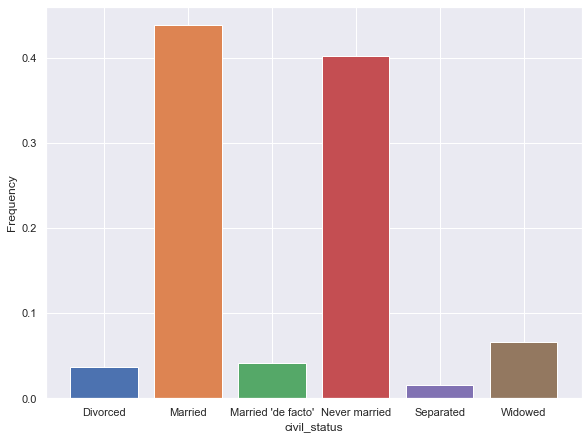

In [28]:
barplot(x='civil_status', data=sociodemo)

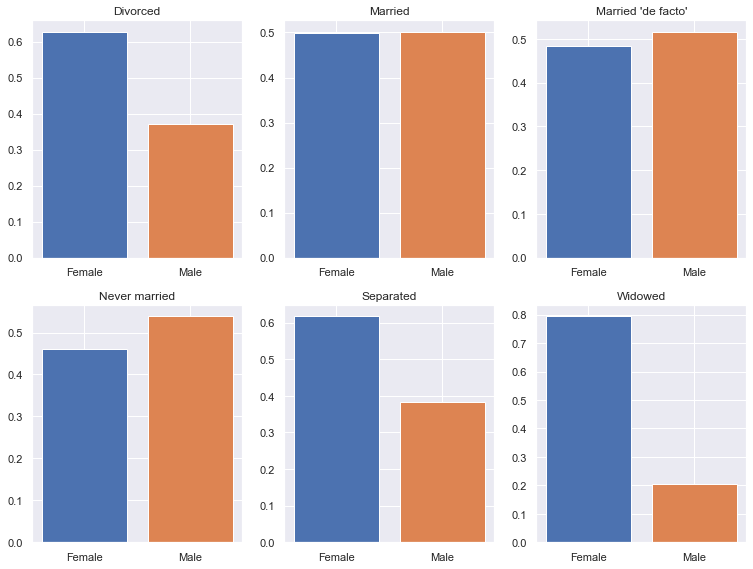

In [29]:
bardiagram(x='civil_status', hue='sex', data=sociodemo)

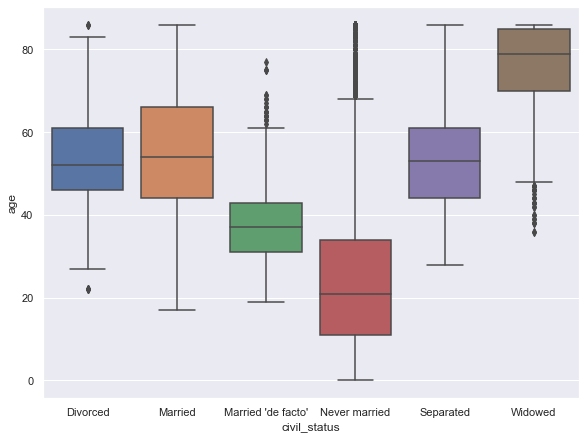

In [30]:
boxplot(x='civil_status', y='age', data=sociodemo)

In [31]:
ilc['Type of household'].unique()

array(['Two adults, no children, one older than 64',
       'Two adults with one children',
       'One adult with one or more children',
       'Other household types with no children',
       'One female, between 30 and 64', 'Two adults with two children',
       'Two adults, no children, both older than 64',
       'One male, between 30 and 64',
       'Two adults with three or more children',
       'One male, older than 64', 'One female, older than 64',
       'Other household types with children', 'One male, younger than 30',
       nan, 'One female, younger than 30'], dtype=object)

In [32]:
familial_status = pd.DataFrame({'weight': ilc['Personal cross-sectional weight']})
familial_status['household_composition'] = ilc['Type of household']
familial_status['household_composition'] = familial_status.household_composition.fillna('Missing')
familial_status.head()

,weight,household_composition
0,906.15830,"Two adults, no children, one older than 64"
1,906.15830,"Two adults, no children, one older than 64"
2,1227.68869,"Two adults, no children, one older than 64"
3,1227.68869,"Two adults, no children, one older than 64"
4,2559.35987,Two adults with one children


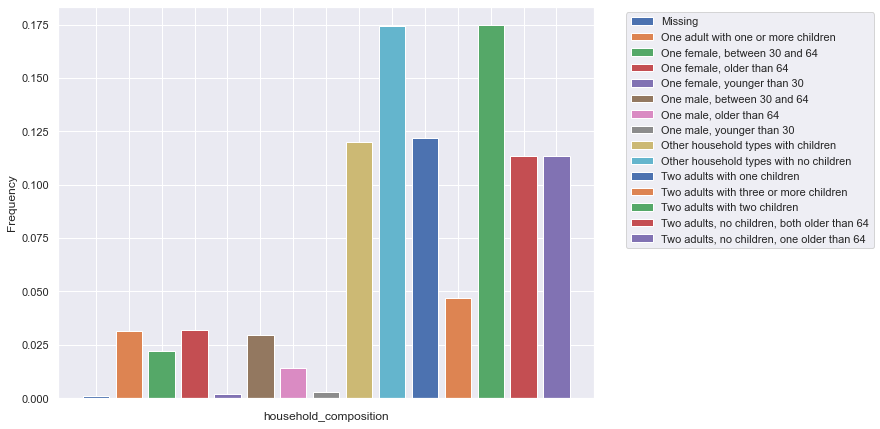

In [33]:
barplot(x='household_composition', data=familial_status, legend=True)

In [34]:
ilc['Type of household'].unique()

array(['Two adults, no children, one older than 64',
       'Two adults with one children',
       'One adult with one or more children',
       'Other household types with no children',
       'One female, between 30 and 64', 'Two adults with two children',
       'Two adults, no children, both older than 64',
       'One male, between 30 and 64',
       'Two adults with three or more children',
       'One male, older than 64', 'One female, older than 64',
       'Other household types with children', 'One male, younger than 30',
       nan, 'One female, younger than 30'], dtype=object)

In [35]:
#Two adults, without childrem, Two adults with children, Single adult, 

In [36]:
mapped_household_composition = {'Two adults, no children, one older than 64': ,
       'Two adults with one children',
       'One adult with one or more children',
       'Other household types with no children',
       'One female, between 30 and 64', 'Two adults with two children',
       'Two adults, no children, both older than 64',
       'One male, between 30 and 64',
       'Two adults with three or more children',
       'One male, older than 64', 'One female, older than 64',
       'Other household types with children', 'One male, younger than 30',
       nan, 'One female, younger than 30'}

SyntaxError: invalid syntax (<ipython-input-36-b6a9103e1d2e>, line 1)

In [ ]:
familial_status['civil_status'] = sociodemo.civil_status
familial_status.head()

In [ ]:
bardiagram(x='household_composition', hue='civil_status', data=familial_status, legend=True)

In [80]:
for c in ilc.columns:
    print(c)

Personal cross-sectional weight
Year of birth
Sex
Basic activity status
Education at pre-school
Education at compulsory school
Childcare at centre-based services
Childcare at day-care centre
Childcare by a professional child-minder at child's home or at child-minder’s home
Childcare by grand-parents, other household members (outside parents), other relatives, friends or neighbours
Childrens’ cross-sectional weight for childcare
Living in household with low employement level
Living in household under risk of poverty
Marital status
Consensual Union
Country of birth
Citizenship
Current education activity
ISCED level currently attended
Year when highest level of education was attained
Highest ISCED level attained
Self-defined current economic status
Whether person has ever worked
Actively looking for a job
Available for work
Status in employment
Occupation
Number of hours usually worked per week in main job
Number of months spent at full-time work as employee
Number of months spent at part